In [ ]:
%pip install scanpy
%pip install anndata
%pip install MuData
%pip install loompy

In [ ]:
from mudata import MuData
import numpy as np
from tqdm import tqdm
import pandas as pd
import anndata
import scanpy
import csv
import sys
import loompy
import logging
import os
from matplotlib import pyplot as plt
import plotly.graph_objects as go

Declare functions needed for preprocessing

In [ ]:
# function reads the loomfile downloaded from Tapestri portal
def read_tapestri_loom(filename):
    """
    Read data from MissionBio's formatted loom file.

    Parameters
    ----------
    filename : str
        Path to the loom file (.loom)

    Returns
    -------
    anndata.AnnData
        An anndata object with the following layers:
        adata.X: GATK calls
        adata.layers['e']: reads with evidence of mutation
        adata.layers['no_e']: reads without evidence of mutation
    """
    loom_file = loompy.connect(filename)

    variant_names, amplicon_names, chromosome, location = (
        loom_file.ra['id'], loom_file.ra['amplicon'], loom_file.ra['CHROM'], loom_file.ra['POS'])

    barcodes = [barcode.split('-')[0] for barcode in loom_file.ca['barcode']]
    adata = anndata.AnnData(np.transpose(loom_file[:, :]), dtype=loom_file[:, :].dtype)
    adata.layers['e'] = np.transpose(loom_file.layers['AD'][:, :])
    adata.layers['no_e'] = np.transpose(loom_file.layers['RO'][:, :])
    adata.var_names = variant_names
    adata.obs_names = barcodes
    adata.varm['amplicon'] = amplicon_names
    adata.varm['chrom'] = chromosome
    adata.varm['loc'] = location

    loom_file.close()

    return adata

def read_HyPR_file(HyPR_file):

    HyPR_array = np.loadtxt(HyPR_file, dtype=str, skiprows=1)
    barcodes = HyPR_array[:, 0]
    with open(HyPR_file, 'r') as f:
        first_line = f.readline().strip()
        values = first_line.split('\t')
        var_names = np.array(values, dtype=str)[:]
    X = np.asarray(HyPR_array[:, 1:], dtype=int)
    if np.size(var_names) != X.shape[1]: # sloppy I shouldn't need this
      var_names = var_names[1:]
    df = pd.DataFrame(X, columns=var_names)
    df.columns = df.columns.str.split('_').str[0]
    collapsed_df = df.groupby(axis=1, level=0).sum()
    collapsed_X = collapsed_df.to_numpy()
    collapsed_var_names = collapsed_df.columns.to_numpy()

    adata_hypr = anndata.AnnData(collapsed_X)
    adata_hypr.obs_names = barcodes

    try:
      adata_hypr.var_names = collapsed_var_names
    except:
      adata_hypr.var_names = collapsed_var_names[1:]

    return adata_hypr

# Function for finding the intersecting barcodes between the modalities
def find_intersecting(mdata):
    """
    Find intersecting barcodes and add 'intersecting' to obs with boolean values.

    Parameters
    ----------
    mdata : object
        The mudata object.

    Raises
    ------
    AssertionError
        If the length of mod_names is not equal to 2.
    """

    mod_names = list(mdata.mod.keys())
    assert len(mod_names) == 2, 'Function not implemented for mod_names with length different from 2'

    obs_1, obs_2 = mdata[mod_names[0]].obs_names, mdata[mod_names[1]].obs_names

    cmn_barcodes, idx_1, idx_2 = np.intersect1d(obs_1, obs_2, return_indices=True)

    # Initializing 'intersecting' columns to False
    mdata[mod_names[0]].obs['intersecting'] = False
    mdata[mod_names[1]].obs['intersecting'] = False

    # Updating 'intersecting' columns where True
    mdata[mod_names[0]].obs['intersecting'].iloc[idx_1] = True
    mdata[mod_names[1]].obs['intersecting'].iloc[idx_2] = True

    logger.info(f"Found {idx_1.size} intersecting barcodes")


def annotate_genotype(mdata, variants, window=4, obs_key='mutant_type',
                      genotype_key='tapestri', phenotype_key='HyPR',
                      ignore_bystanders=False, write_all_as=False,
                      ignore_mixed=False, only_type=None, germline_variants=None):

    adata = mdata.mod[genotype_key]

    # loop through the variants in the variant list
    for variant in variants:

        if obs_key in mdata.mod[phenotype_key].obs:
          pass
        else:
          mdata.mod[phenotype_key].obs[obs_key] = 'unannotated'
          mdata.mod[genotype_key].obs[obs_key] = 'unannotated'

        try:
            idx = adata.var_names.get_loc(variant)
        except KeyError:
            logger.info(str(variant) + ' was not found in the genotype modality anndata')
            continue

        # identify which cells have the variant
        bkg_idx, het_idx, hom_idx = [np.flatnonzero(adata.X[:, idx] == i) for i in (0, 1, 2)]

        if only_type == 'het':
          hom_idx = None
        if only_type == 'hom':
          het_idx = None

        if ignore_bystanders == True:

          if het_idx is not None:
            cmn_barcodes, idx_genotype, idx_phenotype = np.intersect1d(mdata.mod[genotype_key].obs_names[het_idx],
                                                                    mdata.mod[phenotype_key].obs_names, return_indices=True)
            if write_all_as == False:
              mdata.mod[phenotype_key].obs[obs_key][idx_phenotype] = str(variant) + '_het'
              mdata.mod[genotype_key].obs[obs_key][het_idx]= str(variant) + '_het'
            else:
              mdata.mod[phenotype_key].obs[obs_key][idx_phenotype] = write_all_as

          if hom_idx is not None:
            cmn_barcodes, idx_genotype, idx_phenotype = np.intersect1d(mdata.mod[genotype_key].obs_names[hom_idx],
                                                                   mdata.mod[phenotype_key].obs_names, return_indices=True)
            if write_all_as == False:
              mdata.mod[phenotype_key].obs[obs_key][idx_phenotype]= str(variant) + '_hom'
              mdata.mod[genotype_key].obs[obs_key][hom_idx]= str(variant) + '_hom'
            else:
              mdata.mod[phenotype_key].obs[obs_key][idx_phenotype] = write_all_as

        else:

          # identify indices of nearby SNPs that are within the bystander window
          chromosome, location = adata.varm['chrom'][idx], adata.varm['loc'][idx]
          nearby_ = np.where(adata.varm['chrom'] == chromosome)
          idx_ = np.where(np.logical_and(np.asarray(adata.varm['loc'], dtype=int) < int(location + window), np.asarray(adata.varm['loc'], dtype=int) > int(location - window)))
          nearby = np.intersect1d(nearby_, idx_)

          # drop wildcards
          np.delete(nearby, [i for i, var_name in enumerate(adata.var_names[nearby]) if var_name.endswith('*')])

          # drop germline variants from bystander analysis
          if germline_variants is not None:
            print("dropped germline")
            mask = [name in germline_variants for name in adata.var_names]
            germ_indices = np.where(mask)[0]
            bad_idxs = np.intersect1d(germ_indices, nearby)
            nearby = np.setdiff1d(nearby, bad_idxs)

          mut_vals = adata.X[:, nearby]
          mut_vals[mut_vals == 3] = 0
          mut_vals[mut_vals > 1] = 1
          sum_muts = np.sum(mut_vals, axis=1)

          if het_idx is not None:
            pure_het_idx = np.intersect1d(np.argwhere(sum_muts == 1), het_idx)
            not_pure_het_idx = np.intersect1d(np.argwhere(sum_muts != 1), het_idx)
            mdata.mod[genotype_key].obs[obs_key][pure_het_idx] = str(variant) + '_het_pure'
            mdata.mod[genotype_key].obs[obs_key][not_pure_het_idx] = str(variant) + '_het_bystander'

            cmn_barcodes, idx_genotype, idx_phenotype = np.intersect1d(mdata.mod[genotype_key].obs_names[not_pure_het_idx],
                                                                      mdata.mod[phenotype_key].obs_names, return_indices=True)
            mdata.mod[phenotype_key].obs[obs_key][idx_phenotype]= str(variant) + '_het_bystander'
            logger.info(f"Annotated {idx_genotype.size} heterozygous mutants with bystanders")


            cmn_barcodes, idx_genotype, idx_phenotype = np.intersect1d(mdata.mod[genotype_key].obs_names[pure_het_idx],
                                                                      mdata.mod[phenotype_key].obs_names, return_indices=True)
            mdata.mod[phenotype_key].obs[obs_key][idx_phenotype] = str(variant) + '_het_pure'
            logger.info(f"Annotated {idx_genotype.size} pure heterozygous mutants")


          if hom_idx is not None:

            pure_hom_idx = np.intersect1d(np.argwhere(sum_muts == 1), hom_idx)
            not_pure_hom_idx = np.intersect1d(np.argwhere(sum_muts != 1), hom_idx)

            mdata.mod[genotype_key].obs[obs_key][pure_hom_idx] = str(variant) + '_hom_pure'
            mdata.mod[genotype_key].obs[obs_key][not_pure_hom_idx] = str(variant) + '_hom_bystander'

            cmn_barcodes, idx_genotype, idx_phenotype = np.intersect1d(mdata.mod[genotype_key].obs_names[not_pure_hom_idx],
                                                                    mdata.mod[phenotype_key].obs_names, return_indices=True)
            mdata.mod[phenotype_key].obs[obs_key][idx_phenotype] = str(variant) + '_hom_bystander'
            logger.info(f"Annotated {idx_genotype.size} homozygous mutants with bystanders")

            cmn_barcodes, idx_genotype, idx_phenotype = np.intersect1d(mdata.mod[genotype_key].obs_names[pure_hom_idx],
                                                                    mdata.mod[phenotype_key].obs_names, return_indices=True)
            mdata.mod[phenotype_key].obs[obs_key][idx_phenotype] = str(variant) + '_hom_pure'
            logger.info(f"Annotated {idx_genotype.size} pure homozygous mutants")


    if ignore_mixed == False:
      # first, lets find the cells that have mixed edits of the intended variants
      indices = []
      for variant in variants:
        if variant in germline_variants:
          continue

        try:
            indices.append(adata.var_names.get_loc(variant))
        except KeyError:
            logger.info(str(variant) + ' was not found in the genotype modality anndata')
            continue
      idxs = np.asarray(indices).flatten()

      print(idxs)

      edit_array = np.zeros(adata.X[:, idxs].shape)
      edit_array[adata.X[:, idxs] == 1] = 1
      edit_array[adata.X[:, idxs] == 2] = 1
      mixed_idxs = np.argwhere(np.sum(edit_array, axis=1) >= 2).ravel()

      mdata.mod[genotype_key].obs[obs_key][mixed_idxs] = 'mixed_mutant'
      cmn_barcodes, idx_genotype, idx_phenotype = np.intersect1d(mdata.mod[genotype_key].obs_names[mixed_idxs],
                                                                      mdata.mod[phenotype_key].obs_names, return_indices=True)
      mdata.mod[phenotype_key].obs[obs_key][idx_phenotype]= 'mixed_mutant'

def call_germline(tapestri_adata, cutoff=0.25):

  fraction_het = np.mean(tapestri_adata.X == 1, axis=0)
  het_germline = tapestri_adata.var_names[fraction_het > cutoff]

  fraction_hom = np.mean(tapestri_adata.X == 2, axis=0)
  hom_germline = tapestri_adata.var_names[fraction_hom > cutoff]

  return list(het_germline), list(hom_germline)

In [ ]:
import seaborn as sns
def barcode_rank_plot(adata, minimum=0, xmax=None):

  # Sum the UMIs for each cell
  cell_umi_counts_all = adata.X.sum(axis=1)
  cell_idxs = np.argwhere(cell_umi_counts_all > minimum)
  cell_umi_counts = cell_umi_counts_all[cell_idxs]

  # Convert to numpy array if it's not already
  cell_umi_counts = np.array(cell_umi_counts).flatten()

  # Sort the UMI counts in descending order for the rank plot
  sorted_umi_counts = np.sort(cell_umi_counts)[::-1]

  plt.figure(figsize=(5, 4), dpi=150)
  sns.lineplot(x=range(1, len(sorted_umi_counts) + 1), y=sorted_umi_counts)
  plt.xlabel('Barcode Rank')
  plt.ylabel('UMI Count')
  plt.title('Cell Barcode Rank Plot')
  plt.yscale('log')  # Log scale for better visualization
  if xmax is not None:
    plt.xlim(0, xmax)
  plt.show()

In [ ]:
# mount google drive if neccessary
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# define where all the files are on the drive
data_dir = 'path/to/data/directory/'

file_locations = [['tapestri_loom_files/MDM_MX_Ctrl_gDNA.cells.loom', 'HyPR_probe_matrices/MDM_MX_Ctrl_HyPR.txt'],
                  ['tapestri_loom_files/MDM_MX_Pam3CSK4_gDNA.cells.loom', 'HyPR_probe_matrices/MDM_MX_Pam3CSK4_HyPR.txt'],
                  ['tapestri_loom_files/MDM_MX_LPS_gDNA.cells.loom', 'HyPR_probe_matrices/MDM_MX_LPS_HyPR.txt'],
                  ['tapestri_loom_files/MDM_MX_IFNG_gDNA.cells.loom', 'HyPR_probe_matrices/MDM_MX_IFNG_HyPR.txt'],
                  ['tapestri_loom_files/MDM_MX_TGFb_gDNA.cells.loom', 'HyPR_probe_matrices/MDM_MX_TGFb_HyPR.txt'],
                  ['tapestri_loom_files/MDM_MX_IL1b_gDNA.cells.loom', 'HyPR_probe_matrices/MDM_MX_IL1b_HyPR.txt'],
                  ['tapestri_loom_files/MDM_MX_IL10_gDNA.cells.loom', 'HyPR_probe_matrices/MDM_MX_IL10_HyPR.txt']]

sample_names = ['Ctrl', 'Pam3CSK4', 'LPS', 'IFNG', 'TGFb', 'IL1b', 'IL10']

# check to make sure all those files exist
for i in tqdm(range(0, len(file_locations))):
  tap_file = data_dir + file_locations[i][0]
  hypr_file = data_dir + file_locations[i][1]
  if os.path.exists(tap_file):
      pass
  else:
    print(tap_file)
  if os.path.exists(hypr_file):
    pass
  else:
    print(hypr_file)

In [ ]:
# load the count matrices into mdata objects
mdata_list = []
for i in tqdm(range(0, len(file_locations))):
    adata_hypr = read_HyPR_file(data_dir + file_locations[i][1])
    adata_tapestri = read_tapestri_loom(data_dir + file_locations[i][0])
    mdata_list.append(MuData({'HyPR': adata_hypr, 'tapestri': adata_tapestri}))

100%|██████████| 7/7 [07:03<00:00, 60.50s/it]


In [ ]:
# visually inspect barcode rank plots
sns.set_theme()
for i, sample_name in enumerate(sample_names):
  print(sample_name)
  barcode_rank_plot(mdata_list[i].mod['HyPR'])

In [ ]:
# filter cells based on where the UMI cutoff should be
for i, sample_name in enumerate(sample_names):
  if i in [0, 1]:
    scanpy.pp.filter_cells(mdata_list[i].mod['HyPR'], min_counts=1000)
  else:
    scanpy.pp.filter_cells(mdata_list[i].mod['HyPR'], min_counts=3000)

In [ ]:
# find intersecting and remove any cells that are not intersecting across the modalities since we wont need them
for mdata in mdata_list:
  find_intersecting(mdata)
  mdata.mod['tapestri'] = mdata.mod['tapestri'][mdata.mod['tapestri'].obs['intersecting'] == True].copy()
  mdata.mod['HyPR'] = mdata.mod['HyPR'][mdata.mod['HyPR'].obs['intersecting'] == True].copy()

  # re-order the observations
  hypr_order = mdata.mod['HyPR'].obs_names
  mdata.mod['tapestri'] = mdata.mod['tapestri'][hypr_order]

In [ ]:
# create a list of AAVS
chrom, loc, edit_type = [], [], []
variant_names = np.asarray(mdata.mod['tapestri'].var_names.values)
for i in range(0, np.size(variant_names)):
    chrom.append(variant_names[i].split(':')[0])
    loc.append(int(variant_names[i].split(':')[1]))
    edit_type.append(variant_names[i].split(':')[2])

control_editing = []
for i in range(0, len(chrom)):
    if chrom[i] == 'chr19':
        if loc[i] in range(55115745, 55115764):
            if edit_type[i] == "A/G":
                control_editing.append(variant_names[i])
            if edit_type[i] == "T/C":
                control_editing.append(variant_names[i])
        if loc[i] in range(55115752, 55115771):
            if edit_type[i] == "C/T":
                control_editing.append(variant_names[i])
            if edit_type[i] == "G/A":
                control_editing.append(variant_names[i])

In [ ]:
# annotate the genotypes in the mdata objects
pre_stop_codons = ["chr4:153702908:A/G", "chr4:153702934:G/A", "chr9:117708561:A/G", "chr9:117712387:A/G","chr3:38139029:G/A",
                   "chr3:38140849:G/A", "chr9:99137857:A/G", "chr9:99144730:A/G", "chr9:99132634:C/T", "chr2:102164772:A/G"
,"chr2:102166111:A/G", "chr11:117986535:G/A", "chr11:117993239:A/G", "chr6:137207079:A/G", "chr21:33421686:G/A",
"chr21:33432252:C/T", "chr5:132487088:C/T"]

for i, mdata in enumerate(mdata_list):
    annotate_genotype(mdata, control_editing, ignore_bystanders=True, ignore_mixed=True, write_all_as='AAVS')
    annotate_genotype(mdata, pre_stop_codons, ignore_bystanders=True, ignore_mixed=False, germline_variants=[])

In [ ]:
# define a function for clustering the genotypes
from sklearn.cluster import KMeans
def cluster_genotypes(mdata_list, n_genotypes, frequency_cutoff=0.1):

  adatas_listed = [mdata.mod['tapestri'] for mdata in mdata_list]
  temp_adata = anndata.concat(adatas_listed, join='inner', label="batch")

  fraction_het = np.mean(temp_adata.X == 1, axis=0)
  het_germline = list(temp_adata.var_names[fraction_het > frequency_cutoff])

  fraction_hom = np.mean(temp_adata.X == 2, axis=0)
  hom_germline = list(temp_adata.var_names[fraction_hom > frequency_cutoff])

  temp_adata = temp_adata[:, het_germline + hom_germline]

  temp_adata.layers['norm_e'] = temp_adata.layers['e'] / np.sum((temp_adata.layers['e'] + temp_adata.layers['no_e'] + 1), axis=1)[:, np.newaxis]

  scanpy.pp.pca(temp_adata, layer='norm_e')
  kmeans = KMeans(n_clusters=n_genotypes, random_state=0).fit(temp_adata.layers['norm_e'])

  cluster_labels = kmeans.labels_
  temp_adata.obs['cluster_labels'] = cluster_labels

  # scanpy.pl.pca(temp_adata, color=cluster_labels)

  return cluster_labels, temp_adata

In [ ]:
labels, temp_adata = cluster_genotypes(mdata_list, 2)

In [ ]:
# create a concatenated anndata object for the HyPR
adata_hypr_list = [mdata.mod['HyPR'] for mdata in mdata_list]

for anndata_obj, batch_name in zip(adata_hypr_list, sample_names):
    anndata_obj.obs['batch'] = batch_name

concatenated_anndata = anndata.concat(adata_hypr_list)

concatenated_anndata.obs['genotype_cluster'] = labels
concatenated_anndata.obs['stimulation'] = concatenated_anndata.obs['batch'].copy()

# uncomment if you want to write the tapestri to disk

# adata_tapestri_list = [mdata.mod['tapestri'] for mdata in mdata_list]
# for anndata_obj, batch_name in zip(adata_tapestri_list, sample_names):
#     anndata_obj.obs['batch'] = batch_name
# concatenated_tapestri_anndata = anndata.concat(adata_tapestri_list)
# concatenated_tapestri_anndata.obs['genotype_cluster'] = labels
# concatenated_tapestri_anndata.obs['stimulation'] = concatenated_tapestri_anndata.obs['batch'].copy()
# output_path = "where/to/write/h5ad"
# concatenated_tapestri_anndata.write(output_path)

In [ ]:
# preprocess with scanpy
concatenated_anndata.layers['raw'] = concatenated_anndata.X.copy()
scanpy.pp.normalize_total(concatenated_anndata, target_sum=1e4)
scanpy.pp.log1p(concatenated_anndata)
scanpy.tl.pca(concatenated_anndata)
scanpy.pp.neighbors(concatenated_anndata)
scanpy.tl.umap(concatenated_anndata, min_dist=0.5, spread=3)

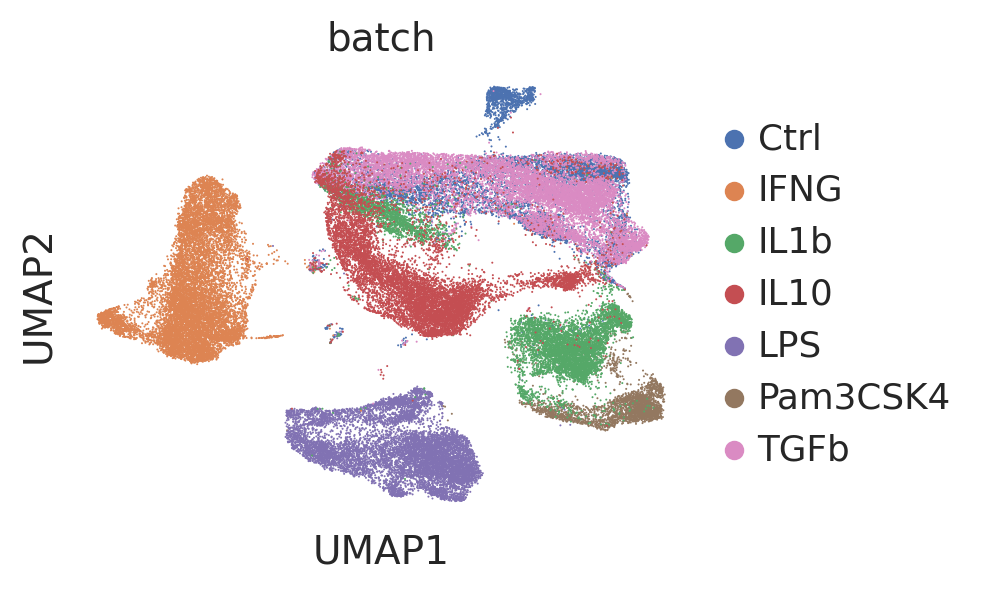

In [ ]:
# Check the UMAP
with plt.rc_context({"figure.figsize": (4, 3), "figure.dpi": (100)}):
  scanpy.pl.umap(concatenated_anndata, color='batch', show=False)
  ax = plt.gca()
  for spine in ax.spines.values():
      spine.set_visible(False)
  plt.show()

In [ ]:
# lets save this as an .h5ad for easy use in Python
output_path = "where/to/save/h5ad/file"
concatenated_anndata.write(output_path)